In [1]:
import os
from pathlib import Path

from ba_tools import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import xgboost
    
# plt.style.use('dark_background')
    
%matplotlib inline

In [2]:
# paths to common data locations - NOTE: to convert any path to a raw string, simply use str(path_instance)
project_parent = Path('./').absolute().parent

data_dir = project_parent/'data'
models_dir = project_parent/'models'

data_raw = data_dir/'raw'
data_ext = data_dir/'external'
data_int = data_dir/'interim'
data_out = data_dir/'processed'

gdb_raw = data_raw/'raw.gdb'
gdb_int = data_int/'interim.gdb'
gdb_out = data_out/'processed.gdb'

# import the project package from the project package path
sys.path.append(str(project_parent/'src'))
import data_engineering_webinar as ace

In [3]:
master_csv = data_int/'full_train.csv'

In [4]:
master_df = pd.read_csv(master_csv, index_col=0)

master_df.head()

,origin_id,tapestryadultsNEW_TADULT01,tapestryadultsNEW_TADULT02,tapestryadultsNEW_TADULT03,tapestryadultsNEW_TADULT04,tapestryadultsNEW_TADULT05,tapestryadultsNEW_TADULT06,tapestryadultsNEW_TADULT07,tapestryadultsNEW_TADULT08,tapestryadultsNEW_TADULT09,...,dstillery_mortgagesinsurance,dstillery_newhomeowners,dstillery_smarthomeproductresearche,dstillery_spaandpoolowners,count_01,count_02,count_03,count_04,count_05,count_06
0,530530701003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.09132,1.15284,0.94226,1.17344,0.0,1.0,0.0,0.0,0.0,0.0
1,530530714071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,1.17959,1.21185,0.98062,2.0,4.0,0.0,0.0,0.0,0.0
2,530530714072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.69580,0.77651,0.85093,0.69087,2.0,0.0,0.0,1.0,0.0,0.0
3,530530714073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.75024,0.98966,0.78169,0.88860,1.0,1.0,1.0,0.0,0.0,0.0
4,530530714112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.10913,1.03365,0.70795,0.93852,3.0,0.0,1.0,0.0,0.0,0.0


In [5]:
proximity_cols = [c for c in master_df.columns if c.startswith('proximity_')]
master_df.iloc[1][proximity_cols]

proximity_traveltime_01                 9.198519
proximity_kilometers_01                 6.296112
proximity_traveltime_02                14.029626
proximity_kilometers_02                11.021534
proximity_traveltime_03                20.273486
proximity_kilometers_03                15.354166
proximity_traveltime_04                28.441571
proximity_kilometers_04                18.121289
proximity_traveltime_05                34.787525
proximity_kilometers_05                25.417287
proximity_traveltime_06                33.875812
proximity_kilometers_06                29.601554
proximity_competition_traveltime_01    13.724384
proximity_competition_kilometers_01     9.498071
proximity_competition_traveltime_02    14.144900
proximity_competition_kilometers_02    11.582369
proximity_competition_traveltime_03    17.163839
proximity_competition_kilometers_03    12.295111
proximity_competition_traveltime_04    16.023081
proximity_competition_kilometers_04    12.323793
proximity_competitio

In [6]:
origin_id_col = 'origin_id'
label_root = 'count'

# identifies label columns - a model will be created for each
label_col_lst = [c for c in master_df.columns if c.startswith(label_root)]

master_df.iloc[1][label_col_lst]

count_01    2.0
count_02    4.0
count_03    0.0
count_04    0.0
count_05    0.0
count_06    0.0
Name: 1, dtype: float64

count_01 r^2 score 0.24079794133522858
count_02 r^2 score 0.3096250632285934
count_03 r^2 score 0.1524139092475033
count_04 r^2 score 0.03217349677527426
count_05 r^2 score -0.0025217793135261513
count_06 r^2 score -0.00840651118438096


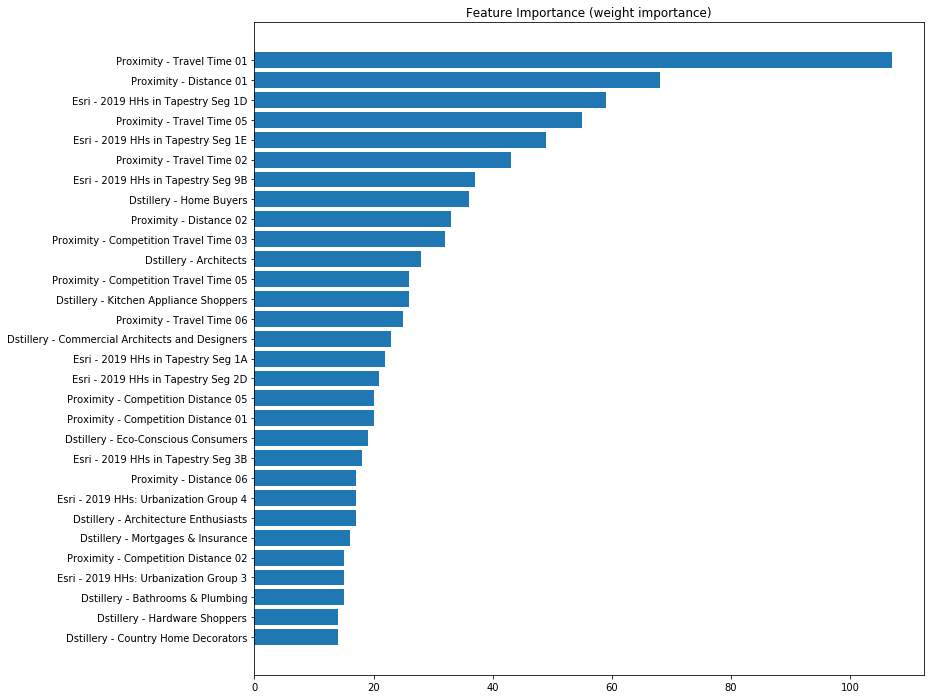

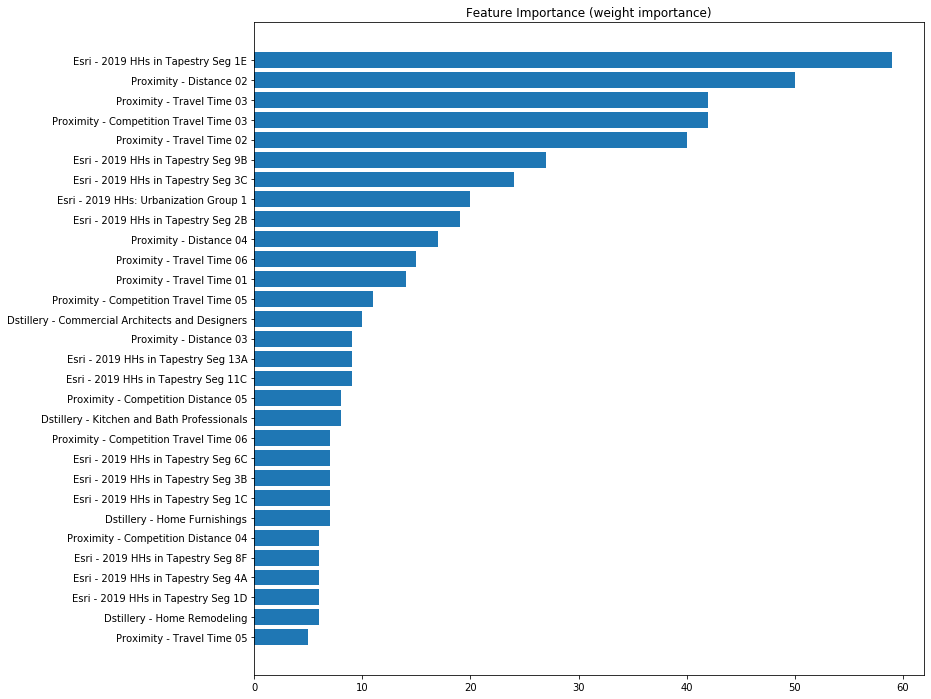

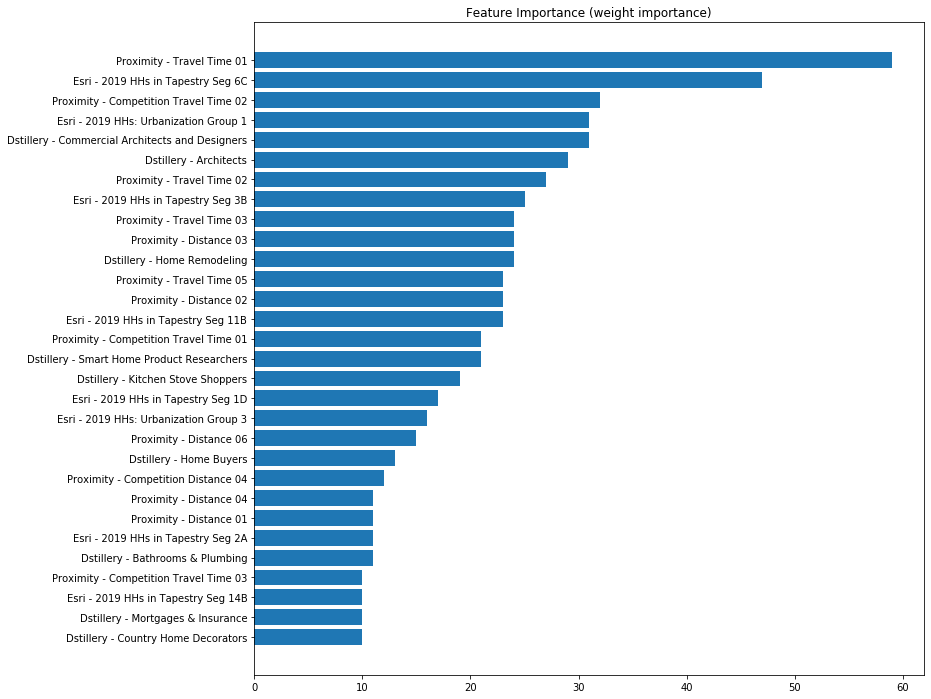

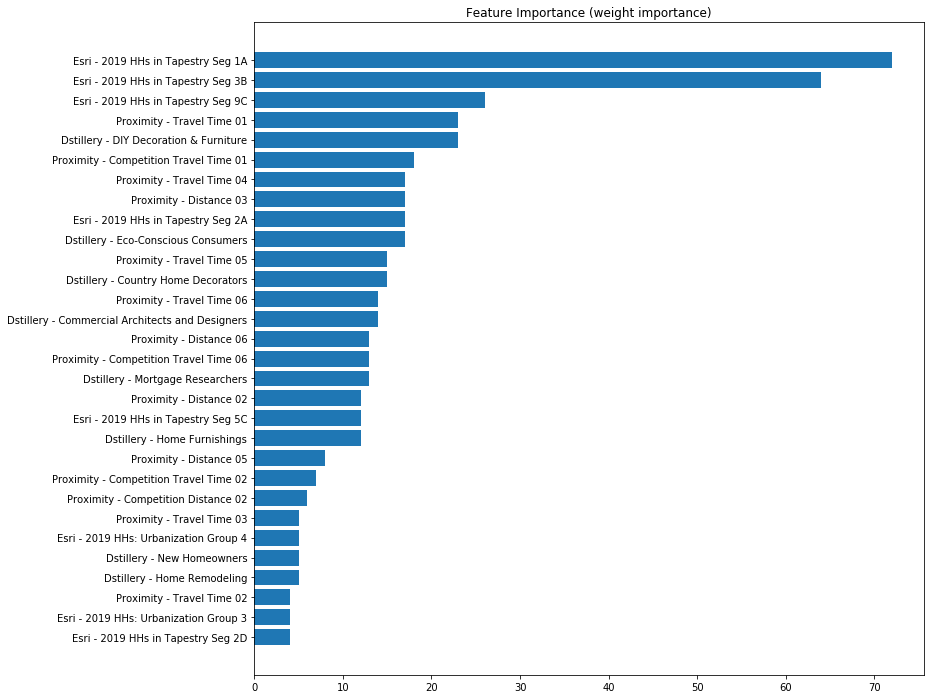

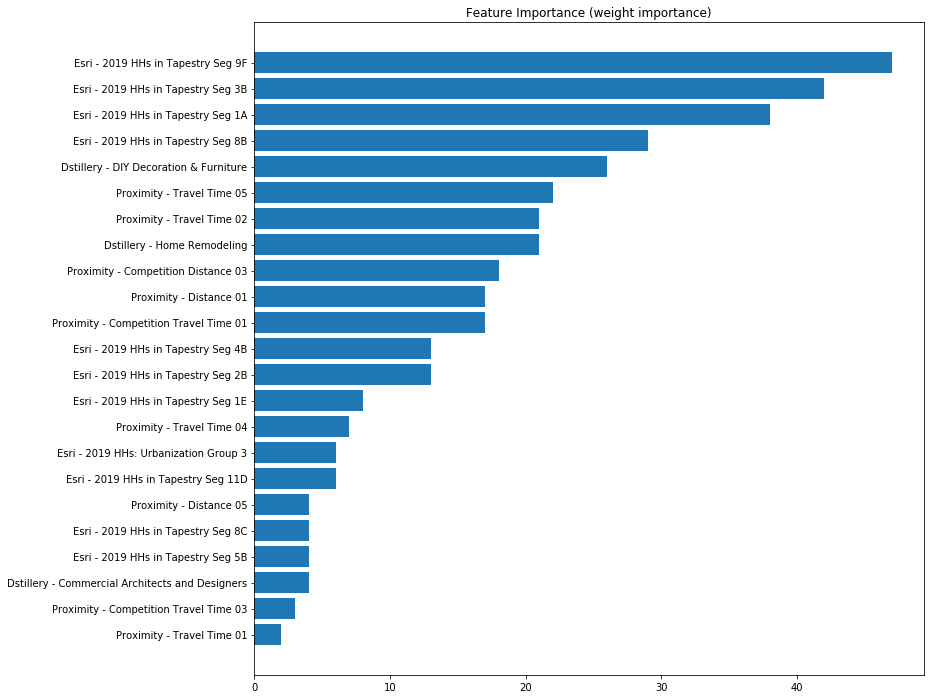

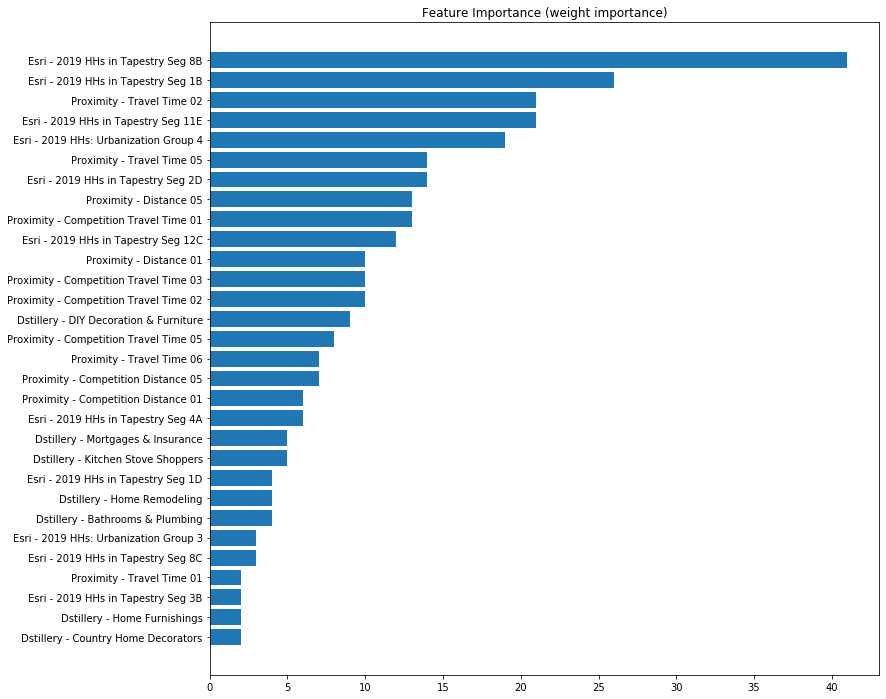

In [7]:
# iterate the columns and create a model for each
for label_col in label_col_lst:

    # for this label column, identify the other labels being excluded form the data in this iteration
    other_lbl_lst = [c for c in label_col_lst if c != label_col]

    # reduce to just columns we are going to use
    train_prep_pipe = Pipeline([
        ('drop_id_cols', preprocessing.ExcludeDestinationIdColumns()),
        ('drop_adult_tap', preprocessing.ExcludeColumnsByStartswith('tapestryadultsNEW_')),
        ('drop_TSEGCODE', preprocessing.ExcludeColumnsByContains('_TSEGCODE_')),
        ('drop_other_labels', preprocessing.ExcludeColumnsByName(other_lbl_lst)),
        ('std_scaler', preprocessing.StandardScaler(label_col))
    ])

    # train the model on this data
    train_df = train_prep_pipe.fit_transform(master_df)

    # identify all the columns not being used, and those that are
    exclude_cols = [origin_id_col, label_col]
    factor_cols = [c for c in train_df.columns if not c in exclude_cols]

    # identify the factors and label data
    X = train_df[factor_cols]
    y = train_df[label_col]

    # split into train and test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # train a model with a few defaults to start with
    xgr = (xgboost.XGBRegressor(n_estimators=1000, learning_rate=0.05)
        .fit(
            X_train, 
            y_train, 
            eval_set=[(X_test, y_test)], 
            eval_metric='rmse',
            early_stopping_rounds=20,
            verbose=False
        )
    )
    
    # save the model
    out_model_name = f"{label_col.replace(label_root, 'xgr_count')}.pkl"
    pickle.dump(xgr, open(models_dir/out_model_name, "wb"))

    # report model accuracy...and given defaults, likely not tremendously high
    y_pred = xgr.predict(X_test)
    print(f'{label_col} r^2 score {r2_score(y_test, y_pred)}')

    # display feature importance to understand primary factors
    out_fig_name = f"{label_col.replace(label_root, 'feature_importance')}.png"
    ace.plot_xgr_feature_importances(xgr, 30, 'weight', out_fig_name, ace.get_alias_srs(train_df))